# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


This is the second attempt to finish the second project. I tried four different CNN 


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'

testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
#assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))

print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

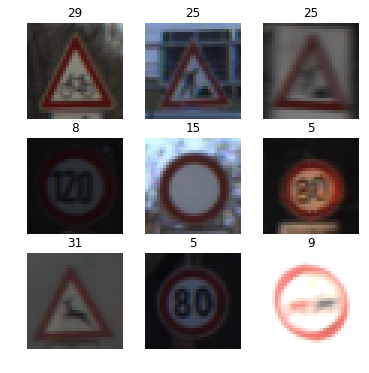

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random 
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# show 9 random training data 
fig, ax = plt.subplots(3,3, figsize=(6, 6))
# https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ravel.html
ax = ax.ravel()
for i in range(9):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_title(y_train[index])


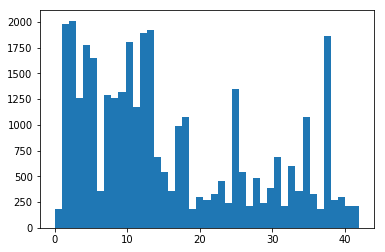

In [4]:
# plot the histogram
plt.hist(y_train, bins = n_classes)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2

# convert to grayscale
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
# https://extr3metech.wordpress.com/2012/09/23/convert-photo-to-grayscale-with-python-opencv/
def getGrayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# normalize train and test image to (-1,1)
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/91cc6685-08df-4277-b53d-3a792b02420d/concepts/71191606550923
# Lecture 6 Introduction to tensorflow, section 23 Normalized Inputs and Initial Weights, @ 1:00
# https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def normalized(img):
    return (img - 128) / 128

def preprocessed(images):
    gray_images = []
    for img in images:
        #gray_images.append(normalized(getGrayscale(img)))
        gray_images.append(getGrayscale(img))
    return np.array(gray_images)


from numpy import newaxis

X_train = preprocessed(X_train)
# https://stackoverflow.com/questions/29241056/the-use-of-numpy-newaxis
X_train = X_train[..., newaxis]
#print(np.mean(X_train))
X_train = normalized(X_train) 
#print(np.mean(X_train))

X_test = preprocessed(X_test)
X_test = X_test[..., newaxis]
X_test = normalized(X_test) 

#X_valid = preprocessed(X_valid)
#X_valid = X_valid[..., newaxis]
#print(np.mean(X_train))
#X_valid = normalized(X_valid)

print("preprocessed train images data shape =", X_train.shape)
print("preprocessed test images data shape =", X_test.shape)
#print("preprocessed valid images data shape =", X_valid.shape)

preprocessed train images data shape = (34799, 32, 32, 1)
preprocessed test images data shape = (12630, 32, 32, 1)


In [6]:
# Generate additional data by rotating some angles

from scipy import ndimage
import random

pics_in_class = np.bincount(y_train)
mean_pics = int(np.mean(pics_in_class))
min_desired = int(mean_pics)

print('Generating new data.')

# Angles to rotate images in additional data made
angles = [-10, 10, -15, 15, -20, 20]

# Iterate through each class
for i in range(len(pics_in_class)):
    
    # Check if less data than the mean
    if pics_in_class[i] < min_desired:
        
        # Count how many additional pictures we want
        new_wanted = min_desired - pics_in_class[i]
        picture = np.where(y_train == i)
        more_X = []
        more_y = []
        
        # Make the number of additional pictures needed to arrive at the mean
        for num in range(new_wanted):
            
            # Rotate images and append new ones to more_X, append the class to more_y
            more_X.append(ndimage.rotate(X_train[picture][random.randint(0,pics_in_class[i] - 1)], random.choice(angles), reshape=False))
            more_y.append(i)
        
        # Append the pictures generated for each class back to the original data
        X_train = np.append(X_train, np.array(more_X), axis=0)
        y_train = np.append(y_train, np.array(more_y), axis=0)
        
print('Additional data generated. Any classes lacking data now have', min_desired, 'pictures.')

Generating new data.
Additional data generated. Any classes lacking data now have 809 pictures.


The updated number of training examples = 46714


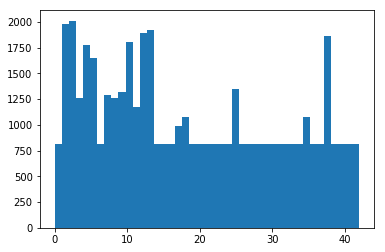

In [7]:
plt.hist(y_train, bins = n_classes)

updated_n_train = len(X_train)
print("The updated number of training examples =", updated_n_train)

In [8]:
# Splitting the training dataset into training and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

### Model Architecture

The architecture used is the [Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/).

![title](images/Deshpande.png)

The first one is the [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf), and the second one is the improve the improved [leNet](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) for traffic sign recognition. 

### Traditional LeNet
![title](images/LeNet.png)

"Usual ConvNets are organized in strict feed-forward layered architectures in which the output of one layer is fed only to the layer above." [leNet](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

In [9]:
# ### Architecture
# **Layer 1: Convolutional.** The output shape should be 28x28x6.
# 
# **Activation.** Your choice of activation function.
# 
# **Pooling.** The output shape should be 14x14x6.
# 
# **Layer 2: Convolutional.** The output shape should be 10x10x16.
# 
# **Activation.** Your choice of activation function.
# 
# **Pooling.** The output shape should be 5x5x16.
# 
# **Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.
# 
# **Layer 3: Fully Connected.** This should have 120 outputs.
# 
# **Activation.** Your choice of activation function.
# 
# **Layer 4: Fully Connected.** This should have 84 outputs.
# 
# **Activation.** Your choice of activation function.
# 
# **Layer 5: Fully Connected (Logits).** This should have 43 outputs.
# 
# ### Output
# Return the result of the 2nd fully connected layer.

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # weight = [filter_size_height, filter_size_width, color_channels, output_depth]

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    # The 'color_channels' is the same as the 'output_depth' of the last convolution weight 
    conv2_W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0_W = tf.Variable(tf.truncated_normal([5*5*16, 400], mu, sigma)) 
    fc0 = tf.reshape(conv2, [-1, fc0_W.get_shape().as_list()[0]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal([400, 120], mu, sigma)) 
    fc1_b = tf.Variable(tf.zeros(120))                      
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal([120, 84], mu, sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet1(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    # weight = [filter_size_height, filter_size_width, color_channels, output_depth]

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x96.
    # The 'color_channels' is the same as the 'output_depth' of the last convolution weight 
    conv2_W = tf.Variable(tf.truncated_normal([5, 5, 32, 96], mu, sigma))
    conv2_b = tf.Variable(tf.zeros(96))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)    
    # Pooling. Input = 10x10x96. Output = 5x5x96.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x96. Output = 2400.
    fc0_W = tf.Variable(tf.truncated_normal([5*5*96, 2400], mu, sigma)) 
    fc0 = tf.reshape(conv2, [-1, fc0_W.get_shape().as_list()[0]])
    
    # Layer 3: Fully Connected. Input = 2400. Output = 600.
    fc1_W = tf.Variable(tf.truncated_normal([2400, 600], mu, sigma)) 
    fc1_b = tf.Variable(tf.zeros(600))                      
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 600. Output = 150.
    fc2_W = tf.Variable(tf.truncated_normal([600, 150], mu, sigma))
    fc2_b = tf.Variable(tf.zeros(150))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 150. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(150, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Improved LeNet

![title](images/ImprovedLeNet.png)

Contrary to the traditional LeNet, only the output of the second stage is fed to the classifer, the output of the first stage is also branched out and fed to the classifier. By adding the procedure, the training yielded higher accuracies than the traditional method.

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ## STAGE 1 ##
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # weight = [filter_size_height, filter_size_width, color_channels, output_depth]
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    ## STAGE 2 ##

    # Layer 2: Convolutional. Output = 10x10x16.
    # The 'color_channels' is the same as the 'output_depth' of the last convolution weight 
    conv2_W = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # layer 3: Convolutional. Output = 1x1x400.
    conv3_W = tf.Variable(tf.truncated_normal([5, 5, 16, 400], mu, sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    # Activation.
    conv3 = tf.nn.relu(conv3)    
    
    ## CLASSIFIER ##
    
    # Flatten layer 2. Input = 5x5x16. Output = 400.
    conv2flat = flatten(conv2)
    print ("conv2flat shape: ", conv2flat.get_shape())   
    # Flatten layer 3. Input = 1x1x400. Output = 400.
    conv3flat = flatten(conv3)
    print ("conv3flat shape: ", conv3flat.get_shape()) 
    
    # Concat conv2flat and conv3flat. Input = 400 + 400. Output = 800
    fc0 = tf.concat([conv3flat, conv2flat], 1)
    print ("fully connection input shape: ", fc0.get_shape())     
    # Dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 300.
    fc1_W = tf.Variable(tf.truncated_normal([800, 300], mu, sigma)) 
    fc1_b = tf.Variable(tf.zeros(300))                      
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 300. Output = 120.
    fc2_W = tf.Variable(tf.truncated_normal([300, 120], mu, sigma))
    fc2_b = tf.Variable(tf.zeros(120))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits 

In [13]:
# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

# https://stackoverflow.com/questions/44887367/tensorflow-tf-one-hot-why-the-shape-of-output-is-defined-by-the-value-of-axis
one_hot_y = tf.one_hot(y, 43)

rate = 0.001
EPOCHS = 40
BATCH_SIZE = 128

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline
Create a training pipeline that uses the model to classify the data.

In [14]:
logits = LeNet1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [15]:
# tf.argmax: https://stackoverflow.com/questions/41708572/tensorflow-questions-regarding-tf-argmax-and-tf-equal
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.

In [16]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        #if i % 5 == 0:
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.396
EPOCH 2 ...
Validation Accuracy = 0.670
EPOCH 3 ...
Validation Accuracy = 0.807
EPOCH 4 ...
Validation Accuracy = 0.878
EPOCH 5 ...
Validation Accuracy = 0.918
EPOCH 6 ...
Validation Accuracy = 0.938
EPOCH 7 ...
Validation Accuracy = 0.952
EPOCH 8 ...
Validation Accuracy = 0.957
EPOCH 9 ...
Validation Accuracy = 0.962
EPOCH 10 ...
Validation Accuracy = 0.966
EPOCH 11 ...
Validation Accuracy = 0.969
EPOCH 12 ...
Validation Accuracy = 0.971
EPOCH 13 ...
Validation Accuracy = 0.973
EPOCH 14 ...
Validation Accuracy = 0.975
EPOCH 15 ...
Validation Accuracy = 0.975
EPOCH 16 ...
Validation Accuracy = 0.977
EPOCH 17 ...
Validation Accuracy = 0.977
EPOCH 18 ...
Validation Accuracy = 0.978
EPOCH 19 ...
Validation Accuracy = 0.977
EPOCH 20 ...
Validation Accuracy = 0.980
EPOCH 21 ...
Validation Accuracy = 0.978
EPOCH 22 ...
Validation Accuracy = 0.980
EPOCH 23 ...
Validation Accuracy = 0.981
EPOCH 24 ...
Validation Accuracy = 0.980
EPOCH 25 ...

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.862


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")